In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interpn
import matplotlib.colors as colors
import pynbody
import h5py

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'iso_aur_short_10hi/'
s = h5py.File(datadir+simulation+'snapdir_004/snapshot_004.0.hdf5', 'r')

sim_time = s['Header'].attrs['Time']
unit_time = s['Header'].attrs['UnitLength_in_cm']/s['Header'].attrs['UnitVelocity_in_cm_per_s']
unit_mass = s['Header'].attrs['UnitMass_in_g']
unit_length = s['Header'].attrs['UnitLength_in_cm']
unit_velocity = s['Header'].attrs['UnitVelocity_in_cm_per_s']

gyr = 3.15569e16
solarmass = 1.989e33
kpc = 3.086e21

In [3]:
s = pynbody.load(datadir+simulation+'snapdir_004/snapshot_004')

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [4]:
mask_clusters_initial = s.s['InitialNumberOfClusters'] > 0
mask_clusters_final = s.s['NumberOfClusters'] > 0

truncation_mass = s.s['ICMFTruncationMass'][mask_clusters_initial]
cluster_masses = s.s['ClusterMass'][mask_clusters_initial].flatten()
cluster_radius = s.s['ClusterRadius'][mask_clusters_initial].flatten()
init_cluster_masses = s.s['InitialClusterMass'][mask_clusters_initial].flatten()
init_cluster_radius = s.s['InitialClusterRadius'][mask_clusters_initial].flatten()
masslostrelax = s.s['MassLostRelaxation'][mask_clusters_initial].flatten()
masslostshock = s.s['MassLostShocks'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

In [5]:
init_cluster_masses.max()*1e10

SimArray(16362683.38188529, '1.99e+43 g')

In [6]:
clusters_birthtime = []
for i, nclt in enumerate(s.s['InitialNumberOfClusters'][mask_clusters_initial]):
  clusters_birthtime.append(np.ones(nclt) * s.s['aform'][mask_clusters_initial][i])
  
clusters_birthtime = np.concatenate(clusters_birthtime)

In [7]:
clusters_disruptiontime = s.s['DisruptionTime'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]

In [8]:
lifetime_myr = (clusters_disruptiontime - clusters_birthtime) * unit_time / gyr * 1e3
lifetime_myr[(lifetime_myr<0)] = 1e3

In [9]:
lifetime_myr.size

57004

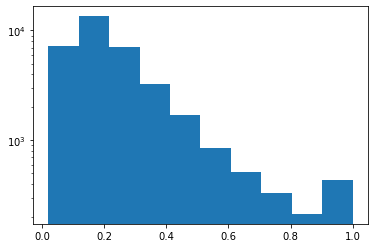

In [10]:
plt.hist(s.s['ClusterFormationEfficiency'][mask_clusters_initial])
plt.yscale('log')

In [11]:
s.physical_units()

In [12]:
s['pos'] = s['pos'] - s.properties['boxsize']/2

In [13]:
msh_mrlx = masslostshock/masslostrelax

min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


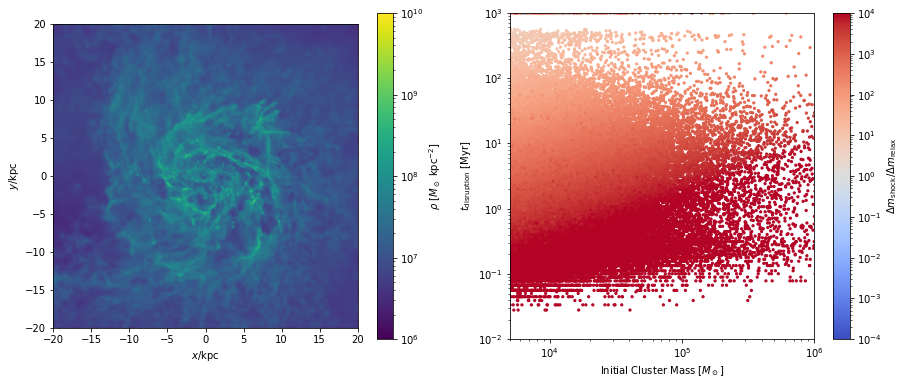

In [43]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))

im = pynbody.plot.sph.image(s.g, qty='rho', units='Msol kpc^-2', vmin=1e6, vmax=1e10, width=40, log=True, axes=ax[0], show_cbar=False, return_image=True)
fig.colorbar(im, ax=ax[0], label=r'$\rho$ [$M_\odot$ $\rm{kpc}^{-2}$]')
# ax[0].tick_params(labelsize=12)

cb = ax[1].scatter(init_cluster_masses*1e10, lifetime_myr, c = msh_mrlx, edgecolors='face', s=5, cmap=cm.coolwarm, norm=cm.colors.LogNorm(vmin=1e-4, vmax=1e4))
ax[1].set(xscale='log', xlim=(5e3, 1e6), yscale='log', ylim=(1e-2, lifetime_myr.max()))
ax[1].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Myr}$]')
cbar = fig.colorbar(cb, ax=ax[1], label=r'$\Delta m_{\rm{shock}}/\Delta m_{\rm{relax}}$')
# ax[1].tick_params(labelsize=12)
# plt.tight_layout()
# plt.savefig('iso_smug_disruption.png')

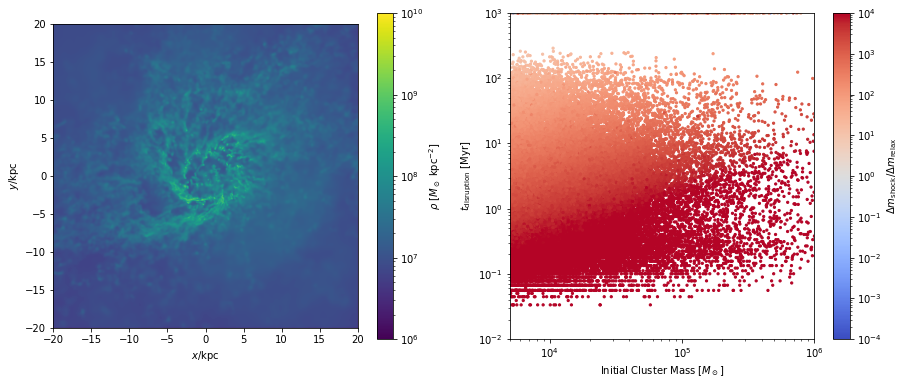

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))

im = pynbody.plot.sph.image(s.g, qty='rho', units='Msol kpc^-2', vmin=1e6, vmax=1e10, width=40, log=True, axes=ax[0], show_cbar=False, return_image=True)
fig.colorbar(im, ax=ax[0], label=r'$\rho$ [$M_\odot$ $\rm{kpc}^{-2}$]')
# ax[0].tick_params(labelsize=12)

cb = ax[1].scatter(init_cluster_masses*1e10, lifetime_myr, c = msh_mrlx, edgecolors='face', s=5, cmap=cm.coolwarm, norm=cm.colors.LogNorm(vmin=1e-4, vmax=1e4))
ax[1].set(xscale='log', xlim=(5e3, 1e6), yscale='log', ylim=(1e-2, lifetime_myr.max()))
ax[1].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Myr}$]')
cbar = fig.colorbar(cb, ax=ax[1], label=r'$\Delta m_{\rm{shock}}/\Delta m_{\rm{relax}}$')
# ax[1].tick_params(labelsize=12)
# plt.tight_layout()
# plt.savefig('iso_smug_disruption.png')

In [15]:
s.s['CltFormActive'].sum()

SimArray(35058, dtype=uint64, '1.00e+00')

In [16]:
mevminit = masslostrelax/init_cluster_masses
mshminit = masslostshock/init_cluster_masses

In [17]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

Text(0, 0.5, 'Inital Cluster Radius [pc]')

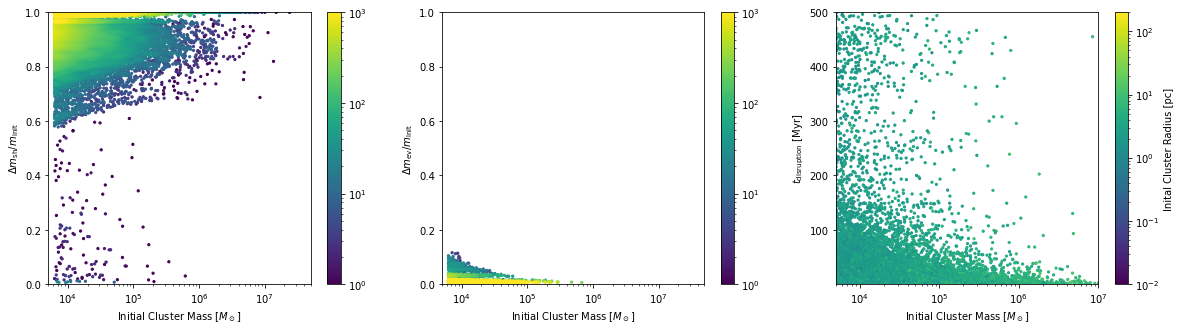

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(init_cluster_masses*1e10, mshminit, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[0])

ax[1], cb1 = density_scatter(init_cluster_masses*1e10, mevminit, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[1])

cb2 = ax[2].scatter(init_cluster_masses*1e10, lifetime_myr, c=init_cluster_radius*1e3, edgecolors='face', s=5, norm=colors.LogNorm(vmin=1e-2, vmax=2e2))
ax[2].set(xscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 500))
ax[2].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Myr}$]')
cbar = fig.colorbar(cb2, ax=ax[2])
cbar.ax.set_ylabel('Inital Cluster Radius [pc]')

Text(0, 0.5, 'Inital Cluster Radius [pc]')

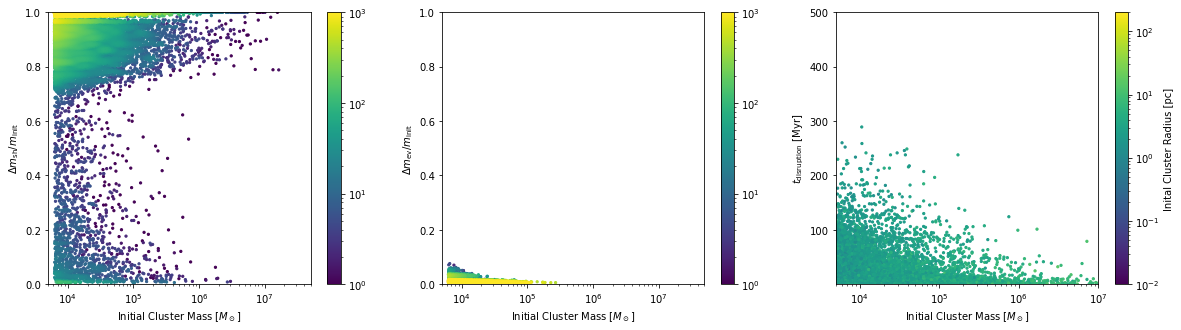

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(init_cluster_masses*1e10, mshminit, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[0])

ax[1], cb1 = density_scatter(init_cluster_masses*1e10, mevminit, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[1])

cb2 = ax[2].scatter(init_cluster_masses*1e10, lifetime_myr, c=init_cluster_radius*1e3, edgecolors='face', s=5, norm=colors.LogNorm(vmin=1e-2, vmax=2e2))
ax[2].set(xscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 500))
ax[2].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Myr}$]')
cbar = fig.colorbar(cb2, ax=ax[2])
cbar.ax.set_ylabel('Inital Cluster Radius [pc]')

Text(0, 0.5, 'Number')

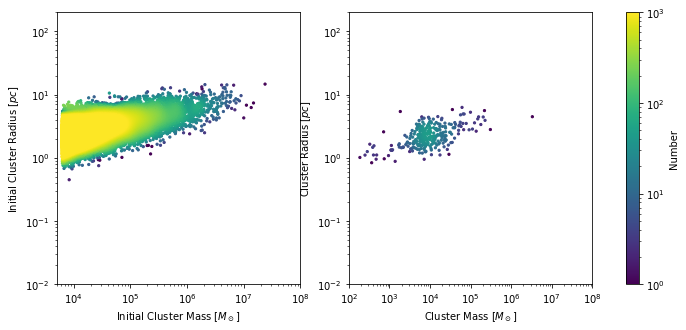

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses*1e10, init_cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(5e3, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

ax[1], cb = density_scatter(cluster_masses*1e10, cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')

Text(0, 0.5, 'Number')

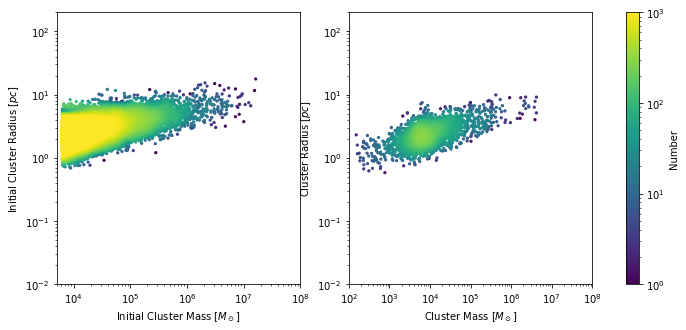

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses*1e10, init_cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(5e3, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

ax[1], cb = density_scatter(cluster_masses*1e10, cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')